In [1]:
! export AWS_PROFILE='sedatalakeprodreadwrite'

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.base import clone
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.model_selection import train_test_split

# import altair as alt
import mlflow

from sklearn.metrics import  make_scorer
from lightgbm import LGBMRanker, LGBMClassifier #, __version__
from lightgbm import plot_importance


from sklearn.metrics import make_scorer, roc_auc_score, precision_score, recall_score
average_precision_scorer = make_scorer(average_precision_score, average='macro')  #, average = 'weighted')
roc_auc_scorer = make_scorer(roc_auc_score, average='macro') #average = 'weighted')

# from mlflow_utils import train_log_model

idx = pd.IndexSlice
import pylab as plt

In [3]:
# import sys
# sys.path.append('../')

# # from propmatch.mlflowcli import log_mlflow
from model import get_model

In [4]:
def precision_at_f(ytrue, y_score, feta=0.95):
    mask = y_score >= feta
    return ytrue[mask].mean()

def recall_at_f(ytrue, y_score, feta=0.95):
    mask = y_score >= feta
    detected = ytrue[mask].sum()
    total = ytrue.sum()
    return detected/total

In [5]:
from mlflow_utils import train_log_model

In [6]:
METRICS = [
    make_scorer(average_precision_score, average='macro'),  #, average = 'weighted')
    make_scorer(roc_auc_score, average='macro'),
    make_scorer(precision_at_f, needs_proba=True, greater_is_better=True),
    make_scorer(recall_at_f, needs_proba=True, greater_is_better=True)
]


## Load Data

In [7]:
files = Path('./data/candidates_georef_v4').glob('*.parquet')

In [8]:
data = pd.concat((pd.read_parquet(str(f)) for f in files))

In [9]:
data.columns

Index(['sale_id', 'trxn_id', 'trxn_price', 'listing_price', 'correct_sale_id',
       'lottype_cat', 'unittype_cat', 'spatial', 'days', 'price_diff',
       'price_pct_diff', 'partial_street_score', 'partial_unit_score', 'total',
       'same_zipcode', 'listing_unit', 'closing_unit', 'listing_street',
       'closing_street', 'trxn_zip', 'trxn_city', 'trxn_state', 'listing_zip',
       'listing_city', 'area_id', 'x', 'y', 'distance', 'azimuth',
       'building_in_10', 'same_complex', 'same_building_id', 'same_block',
       'same_bin', 'same_building_bbl', 'same_bbl', 'same_unittype',
       'same_unit', 'candidates', 'trxn_candidates', 'status'],
      dtype='object')

In [10]:
print(f'Total pairs: {len(data):,d}, matched: {data["correct_sale_id"].nunique():,d} ({data["correct_sale_id"].nunique()/len(data):.2%})')

Total pairs: 1,075,485, matched: 3,646 (0.34%)


In [11]:
data['match'] = (data['sale_id'] == data['correct_sale_id']).astype(int)

In [12]:
data.isnull().mean().sort_values()

trxn_city               0.000000
trxn_candidates         0.000000
same_unit               0.000000
same_unittype           0.000000
same_bbl                0.000000
same_building_bbl       0.000000
same_bin                0.000000
same_block              0.000000
same_building_id        0.000000
same_complex            0.000000
trxn_state              0.000000
trxn_zip                0.000000
closing_street          0.000000
closing_unit            0.000000
match                   0.000000
trxn_price              0.000000
lottype_cat             0.000000
listing_unit            0.000010
candidates              0.000010
listing_price           0.000010
spatial                 0.000010
price_diff              0.000010
building_in_10          0.000010
same_zipcode            0.000010
distance                0.000010
y                       0.000010
azimuth                 0.000010
area_id                 0.000010
listing_city            0.000010
listing_zip             0.000010
price_pct_

## Features

In [13]:
features = ['spatial', 'days', 'price_pct_diff', 
            'partial_unit_score',
            "partial_street_score",
            'same_unit',
            'same_building_id', 
            'same_bin',
            'same_complex',
            "candidates",
            "same_zipcode",
            "building_in_10",
#             "closing_candidates", 
            'same_unittype', 
#             'same_rd_normalized_unit',
#             'unittype_cat',
            'x', 'y', 'distance', 'azimuth'
            ]

ycol = 'match'

In [14]:
X = data[features]
y = data[ycol]

In [15]:
bool_cols = ['same_unit', 'same_building_id', 'same_bin', 'same_complex', 'same_zipcode', 'building_in_10', 'same_unittype']
X[bool_cols] = X[bool_cols].astype(bool).astype(int)

/var/folders/v2/l685f8rj7jn4flt11pny4lsr0000gq/T/ipykernel_93703/1724854506.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_cols] = X[bool_cols].astype(bool).astype(int)


In [16]:
X.select_dtypes('object').head(2)

""
0
1


## Validation Set

In [17]:
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.1, random_state=2024, stratify=y)

In [18]:
f"Training set size {len(ytrain):,d}, matched: {ytrain.mean():.2%}"

'Training set size 967,936, matched: 0.34%'

In [19]:
f"Validation set size {len(yval):,d}, matched: {yval.mean():.2%}"

'Validation set size 107,549, matched: 0.34%'

## Dealing with Imbalance

In [20]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN

In [75]:
ros = RandomOverSampler(random_state=2024, sampling_strategy=0.05)
X_resampled_05, y_resampled_05 = ros.fit_resample(Xtrain, ytrain)

In [69]:
ros = RandomOverSampler(random_state=2024, sampling_strategy=0.1)
X_resampled_10, y_resampled_10 = ros.fit_resample(Xtrain, ytrain)

In [70]:
ros = RandomOverSampler(random_state=2024, sampling_strategy=0.15)
X_resampled_15, y_resampled_15 = ros.fit_resample(Xtrain, ytrain)

In [21]:
ros = RandomOverSampler(random_state=2024, sampling_strategy=0.2)
X_resampled_20, y_resampled_20 = ros.fit_resample(Xtrain, ytrain)

In [22]:
ros = RandomOverSampler(random_state=2024, sampling_strategy=0.3)
X_resampled_30, y_resampled_30 = ros.fit_resample(Xtrain, ytrain)

In [23]:
ros = RandomOverSampler(random_state=2024, sampling_strategy=0.4)
X_resampled_40, y_resampled_40 = ros.fit_resample(Xtrain, ytrain)

In [59]:
ros = RandomOverSampler(random_state=2024, sampling_strategy=0.5)
X_resampled_50, y_resampled_50 = ros.fit_resample(Xtrain, ytrain)

In [24]:
mask = Xtrain.notnull().all(1)

X_resampled_smote, y_resampled_smote = SMOTE().fit_resample(Xtrain[mask], ytrain[mask])

In [25]:
X_resampled_adasyn, y_resampled_adasyn = ADASYN().fit_resample(Xtrain[mask], ytrain[mask])

## Model

In [47]:
metaflow_config = dict(
    tracking_uri='https://mlflow.production.streeteasy.cloud',
    experiment_name='expert_transaction_matching',
    model_name='expert_transaction_matching'
)

In [57]:
def mlflow_log_model(model, Xtrain, ytrain, metaflow_config, tags, model_metadata, validation):
    mlflow.set_tracking_uri(metaflow_config['tracking_uri'])  # type: ignore
    mlflow.set_experiment(metaflow_config['experiment_name'])
    
    mlflow.autolog()
    with mlflow.start_run(run_name=metaflow_config.get('run_name')) as run:
        model.fit(Xtrain, ytrain)
        mlflow.set_tags(tags)
        
        mlflow.log_params(model.get_params())
        
#         mlflow.sklearn.log_model(
#             model,
#             # signature=signature,
#             registered_model_name=metaflow_config['model_name'],
#             artifact_path="model",
#             metadata=model_metadata,
#         )
        if validation:
            Xval, yval, scorers = validation
            val_metrics = {
             f'val_{scorer._score_func.__name__}': scorer(model, Xval, yval) for scorer in scorers
            }
            mlflow.log_metrics(val_metrics)
    return model

In [29]:
params = {'model__colsample_bytree': 0.5013544317317782,
 'model__min_child_samples': 51,
 'model__min_child_weight': 1e-05,
 'model__num_leaves': 21,
 'model__reg_alpha': 0.1,
 'model__reg_lambda': 5,
 'model__subsample': 0.4301443471481221
}


In [30]:
model = get_model(LGBMClassifier).set_params(**params)
# model.steps = model.steps[1:]
# model.steps[0][1].transformers[0][1].sparse_output = False

In [31]:
scoring={'average_precision': average_precision_scorer,
         'roc_auc': roc_auc_scorer}

In [32]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

In [33]:
model = get_model(LGBMClassifier).set_params(**params)

metrics = cross_validate(model, Xtrain, ytrain, 
                         cv=skf, return_train_score=False,
                         scoring=scoring)

pd.DataFrame(metrics)[['test_average_precision','test_roc_auc']].agg(['mean', 'std']).T

,mean,std
test_average_precision,0.560208,0.017228
test_roc_auc,0.905680,0.006978


In [34]:
model = get_model(LGBMClassifier).set_params(**params)

metrics = cross_validate(model, X_resampled_20, y_resampled_20,
                         cv=skf, return_train_score=False,
                         scoring=scoring)

pd.DataFrame(metrics)[['test_average_precision','test_roc_auc']].agg(['mean', 'std']).T

,mean,std
test_average_precision,0.989420,0.000566
test_roc_auc,0.998931,0.000058


## Validation Performance

In [39]:
mlflow.__version__

'2.11.3'

In [76]:
models = dict()

for name, (x_, y_) in {
#     'initial' : (Xtrain, ytrain),
    'resampled_05': (X_resampled_05, y_resampled_05),
#     'resampled_10': (X_resampled_10, y_resampled_10),
#     'resampled_15': (X_resampled_15, y_resampled_15),
#     'resampled_20': (X_resampled_20, y_resampled_20),
#     'resampled_30': (X_resampled_30, y_resampled_30),
#     'resampled_40': (X_resampled_40, y_resampled_40),
#     'resampled_50': (X_resampled_50, y_resampled_50),
#     'resampled_smote': (X_resampled_smote, y_resampled_smote),
#     'resampled_adasyn': (X_resampled_adasyn, y_resampled_adasyn),
    
}.items():
    model = get_model(LGBMClassifier).set_params(**params)
    metaflow_config['run_name'] = f'binary_lbgm_data_{name}'
    models[name] = mlflow_log_model(
        model,
        x_,
        y_,
        metaflow_config, 
        tags=dict(target='matching'), 
        model_metadata={'sampling':name},
        validation=(Xval, yval, METRICS)
    )

2024/03/25 15:30:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2024/03/25 15:30:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/03/25 15:30:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/philippk/Library/Caches/pypoetry/virtualenvs/transaction-matching-i9O2AM3V-py3.10/lib/python3.10/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values 

## Analize Results

In [77]:
runs = mlflow.search_runs('793')

In [78]:
metric_cols = [el for el in runs.columns if el.startswith('metrics')]
cols = ['tags.mlflow.runName', ] + metric_cols

runs[cols].set_index('tags.mlflow.runName')

,metrics.val_recall_at_f,metrics.val_precision_at_f,metrics.val_average_precision_score,metrics.val_roc_auc_score
tags.mlflow.runName,,,,
binary_lbgm_data_resampled_05,0.742466,0.724599,0.635028,0.989501
binary_lbgm_data_resampled_15,0.961644,0.664773,0.616485,0.992143
binary_lbgm_data_resampled_10,0.942466,0.679842,0.629601,0.992199
binary_lbgm_data_resampled_50,0.972603,0.654982,0.586937,0.992008
binary_lbgm_data_resampled_adasyn,0.824658,0.665929,0.607769,0.983947
binary_lbgm_data_resampled_smote,0.827397,0.671111,0.613368,0.985331
binary_lbgm_data_resampled_40,0.969863,0.660448,0.594801,0.992045
binary_lbgm_data_resampled_30,0.967123,0.661049,0.602879,0.992082
binary_lbgm_data_resampled_20,0.961644,0.662264,0.614352,0.992134


In [79]:
print('Best model according to metric:')
runs[cols].set_index('tags.mlflow.runName').idxmax()

Best model according to metric:


metrics.val_recall_at_f                binary_lbgm_data_resampled_50
metrics.val_precision_at_f                  binary_lbgm_data_initial
metrics.val_average_precision_score    binary_lbgm_data_resampled_05
metrics.val_roc_auc_score              binary_lbgm_data_resampled_10
dtype: object

## Plots for best model: **binary_lbgm_data_resampled_10**

In [81]:
model = get_model(LGBMClassifier).set_params(**params).fit(X_resampled_10, y_resampled_10)

2024/03/25 15:32:06 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e72e9a8f2d394be5b60199b7fc6f6863', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/03/25 15:32:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/philippk/Library/Caches/pypoetry/virtualenvs/transaction-matching-i9O2AM3V-py3.10/lib/python3.10/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these column

In [82]:
y_proba = model.predict_proba(Xval)[:, 1]

In [86]:
# model

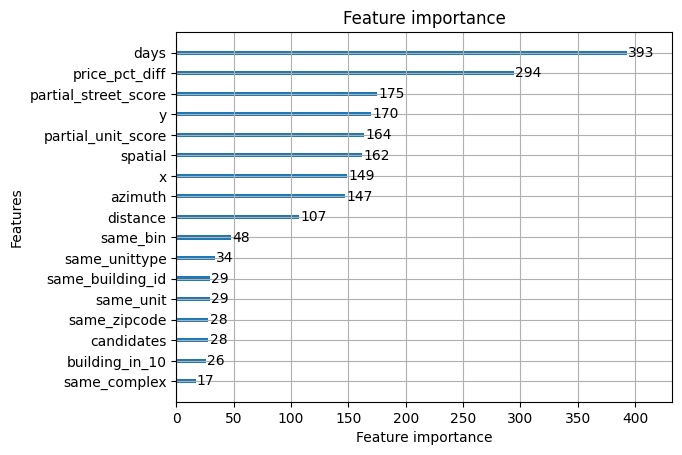

In [89]:
plot_importance(model.steps[0][1]);
plt.show()

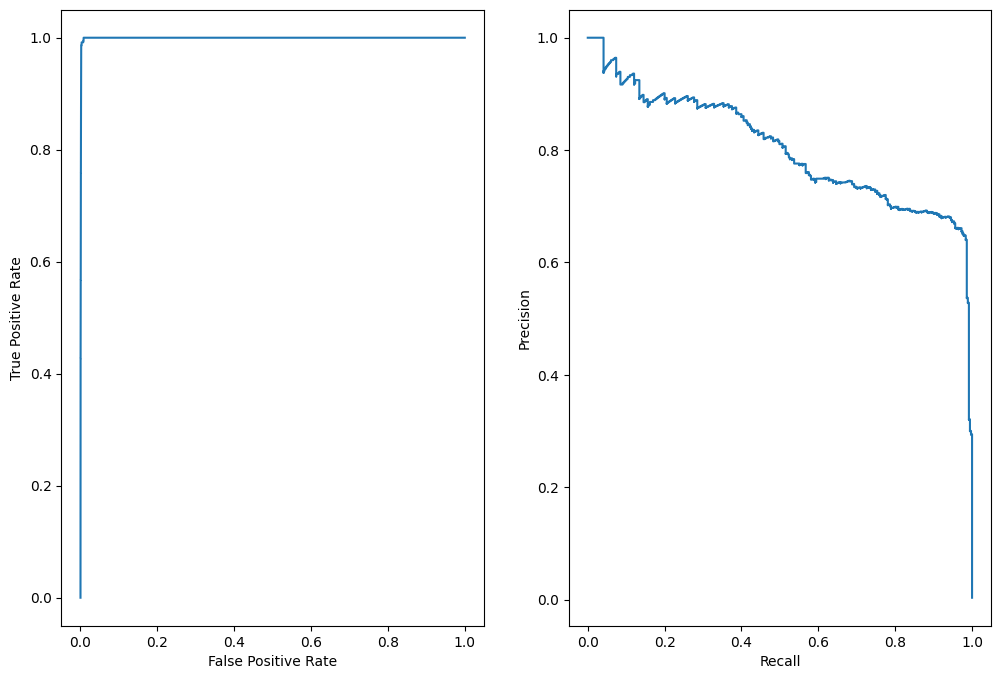

In [90]:
fpr, tpr, _ = roc_curve(yval, y_proba, pos_label=1)
prec, recall, _ = precision_recall_curve(yval, y_proba, pos_label=1)

pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()

### Threshold Curve

In [91]:
prec, recall, step = precision_recall_curve(yval, y_proba, pos_label=1)

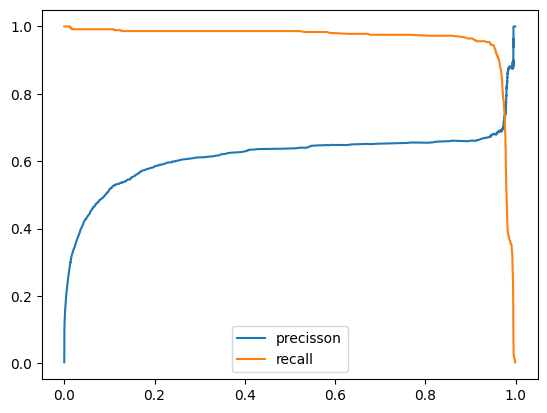

In [95]:
pd.DataFrame({'precisson':prec[:-1], 'recall':recall[:-1]}, index=step).plot();
plt.show()

### Calibration

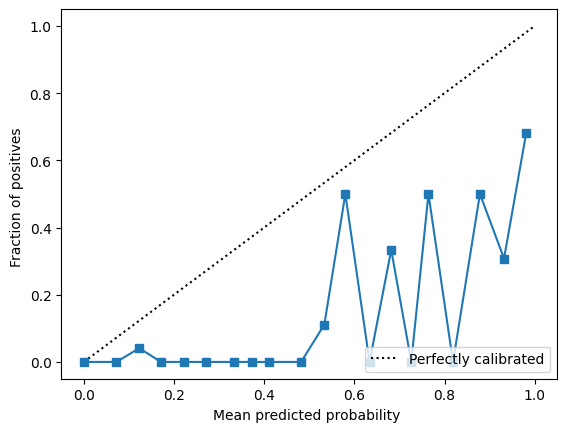

In [98]:
prob_true, prob_pred = calibration_curve(yval, y_proba, n_bins=20)
disp = CalibrationDisplay(prob_true, prob_pred, y_proba)
disp.plot()
plt.show()